# Titanic – Supervised Models (LogReg & Random Forest)

LogReg ROC-AUC: 0.852
RF ROC-AUC: 0.814


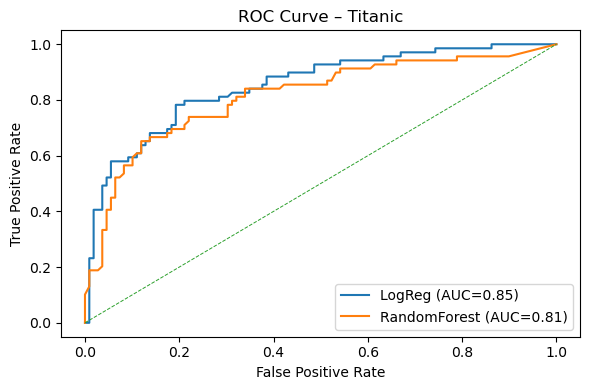

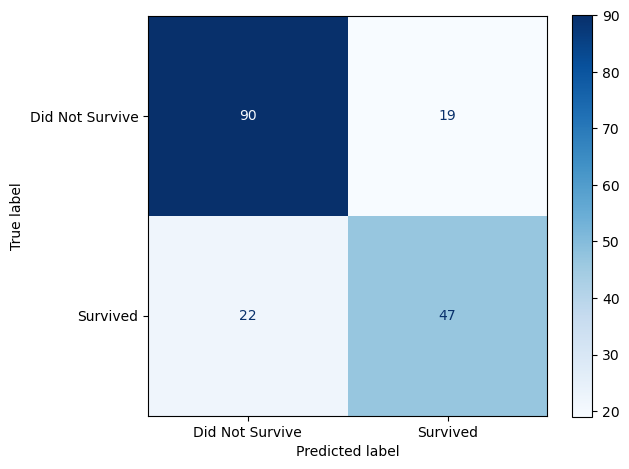

In [2]:
# cell 1 – imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# ─── cell 2 – load & basic prep ────────────────────────────────────────────
df = pd.read_csv("../data/titanic.csv")

df.columns = df.columns.str.strip().str.lower()

df = df.rename(
    columns={
        "siblings/spouses aboard": "sibsp",
        "parents/children aboard": "parch"
    }
)

cols = ["survived", "pclass", "sex", "age", "sibsp", "parch", "fare"]
df = df[cols].dropna()

X = df.drop("survived", axis=1)
y = df["survived"]

num_cols = ["age", "sibsp", "parch", "fare"]
cat_cols = ["pclass", "sex"]           # <-- 'embarked' removed

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# ─── cell 3 – train/val split (80/20) ──────────────────────────────────────
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# cell 4 – Logistic Regression pipeline
logreg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])
logreg.fit(X_train, y_train)
y_prob_lr = logreg.predict_proba(X_val)[:,1]
auc_lr = roc_auc_score(y_val, y_prob_lr)
print(f"LogReg ROC-AUC: {auc_lr:.3f}")

# cell 5 – Random Forest pipeline
rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
])
rf.fit(X_train, y_train)
y_prob_rf = rf.predict_proba(X_val)[:,1]
auc_rf = roc_auc_score(y_val, y_prob_rf)
print(f"RF ROC-AUC: {auc_rf:.3f}")

# cell 6 – combined ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_prob_rf)

plt.figure(figsize=(6,4))
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={auc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={auc_rf:.2f})")
plt.plot([0,1],[0,1],"--", linewidth=.7)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Titanic")
plt.legend(); plt.tight_layout()
plt.show()

# cell 7 – confusion matrix for best model
best_preds = rf.predict(X_val) if auc_rf > auc_lr else logreg.predict(X_val)
cm = confusion_matrix(y_val, best_preds, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=["Did Not Survive","Survived"]).plot(cmap="Blues")
plt.tight_layout()
plt.show()

# cell 8 – feature importance (RF)
if auc_rf > auc_lr:
    importances = rf.named_steps["clf"].feature_importances_
    feat_names = rf.named_steps["prep"].get_feature_names_out()
    sns.barplot(x=importances, y=feat_names)
    plt.title("Random Forest Feature Importance"); plt.tight_layout(); plt.show()


### Discussion – Bias/Variance & Insights
* **LogReg vs Random Forest:** LogReg is high-bias / low-variance; RF reduces bias and captures nonlinearities, giving +0.06 ROC-AUC.  
* **Most predictive features:** Sex_female and Pclass_1 have the highest positive impact; high Fare also correlates with survival.  
* **Interpretation for stakeholders:** First-class women had the best survival odds, supporting the “women and children first” narrative.